In [ ]:

from tqdm import tqdm
import urllib.request

url = "https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt"
r = urllib.request.urlopen(url)
total_size = int(r.headers['Content-Length']) / 1000


In [ ]:
def readIter(f, blocksize=1000):
    """Given a file 'f', returns an iterator that returns bytes of
    size 'blocksize' from the file, using read()."""
    while True:
        data = f.read(blocksize)
        if not data: break
        yield data

with open('expression.bin', 'wb') as f:
    for data in tqdm(readIter(r), total=total_size, unit='KB', unit_scale=False):
        f.write(data)

121130KB [00:02, 46923.01KB/s]                                


In [ ]:
pip install scvi-tools

In [ ]:
%load_ext autoreload
%autoreload 2
import scvi
import tensorflow as tf


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:

import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X = pd.read_csv("expression.bin", sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
cell_types, labels = np.unique(clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])



In [ ]:
X

10    11    12    13    14    15    16    17    18     \
tissue                  1     1     1     1     1     1     1     1     1   
sscortex                0     3     3     0     1     0     0    11     1   
sscortex.1              0     1     1     0     1     0     0     0     0   
sscortex.2              0     0     6     0     1     0     2    25     1   
sscortex.3              3     2     4     0     0     0     3     1     0   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ca1hippocampus.1311     0     0     0     0     0     0     0     0     0   
ca1hippocampus.1312     0     0     0     0     0     0     0     0     1   
sscortex.1689           0     0     0     0     0     0     0     0     0   
ca1hippocampus.1313     0     0     0     0     0     0     0     0     1   
sscortex.1690           1     1     0     0     0     0     0     0     1   

                    19     ... 19972 19973 19974 19975 19976 19977 19978  \
tissue                  1  ...     0     0     0     0     0     0     0   
sscortex                0  ...     0     0     0     0     0     0     0   
sscortex.1              0  ...     0     0     0     0     0     0     0   
sscortex.2              0  ...     0     0     0     0     0     0     0   
sscortex.3              0  ...     0     0     0     0     0     0     0   
...                   ...  ...   ...   ...   ...   ...   ...   ...   ...   
ca1hippocampus.1311     0  ...     0     0     0     0     0     0     0   
ca1hippocampus.1312     0  ...     0     0     0     0     0     0     0   
sscortex.1689           0  ...     0     0     0     0     0     0     0   
ca1hippocampus.1313     0  ...     0     0     0     0     0     0     0   
sscortex.1690           0  ...     0     0     0     0     0     0     0   

                    19979 19980 19981  
tissue                  0     0     0  
sscortex                0     0     0  
sscortex.1              0     0     0  
sscortex.2              0     0     0  
sscortex.3              0     0     0  
...                   ...   ...   ...  
ca1hippocampus.1311     0     0     0  
ca1hippocampus.1312     0     0     0  
sscortex.1689           0     0     0  
ca1hippocampus.1313     0     0     0  
sscortex.1690           0     0     0  

[3006 rows x 19972 columns]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_codebooks, archetype_lambda=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.codebook = nn.Parameter(torch.randn(num_codebooks, latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Softplus()  # To output positive  for NB
        )

        self.latent_dim = latent_dim
        self.archetype_lambda = archetype_lambda

    def forward(self, x):
        z_e = self.encoder(x)  # (B, latent_dim)
        # Compute distances to codebook entries
        dist = torch.cdist(z_e, self.codebook)  # (B, K)
        indices = torch.argmin(dist, dim=1)
        z_q = self.codebook[indices]

        # Decoder
        x_hat = self.decoder(z_q)

        # Commitment + quantization loss (VQ-VAE-style)
        commit_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())
        vq_loss = commit_loss + codebook_loss

        # Archetypal regularization (approximate convex hull constraint)
        weights = F.softmax(torch.matmul(self.codebook, z_e.T), dim=1)  # (K, B)
        archetype_targets = torch.matmul(weights, z_e)  # (K, latent_dim)
        archetype_loss = F.mse_loss(self.codebook, archetype_targets)

        # diversity loss (inside forward)
        usage_counts = torch.bincount(indices, minlength=self.codebook.shape[0]).float()
        prob_dist = usage_counts / (usage_counts.sum() + 1e-6)
        diversity_loss = -torch.sum(prob_dist * torch.log(prob_dist + 1e-6))  # entropy-based


        return x_hat, vq_loss, self.archetype_lambda * archetype_loss,diversity_loss, indices

    def generate(self, num_samples):
        codebook_ids = torch.randint(0, self.codebook.shape[0], (num_samples,))
        z_q = self.codebook[codebook_ids]
        return self.decoder(z_q)

# training loop
def train_vqvae(model, data_loader, epochs=50, lr=1e-3,device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for (x,) in data_loader:
            x = x.to(device).float()
            x_hat, vq_loss, arch_loss, diversity_loss, _ = model(x)
            recon_loss = F.mse_loss(x_hat, x)
            loss = recon_loss + vq_loss + arch_loss - 0.5 * diversity_loss  # negative---> maximize entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

# For dataset loading
class TensorDatasetFromDF(Dataset):
    def __init__(self, df, log_norm=True):
        x = torch.tensor(df.values, dtype=torch.float32)
        if log_norm:
            x = x / (x.sum(dim=1, keepdim=True) + 1e-8)
            x = torch.log1p(x)
        self.data = x

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx],


def make_dataloader(df, batch_size=64, log_norm=True, shuffle=True):
    dataset = TensorDatasetFromDF(df, log_norm=log_norm)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Step 1: Convert to Tensor Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader

# Ensure `X` now only includes numeric expression values (cells x genes)
X_tensor = torch.tensor(X.values.astype(float), dtype=torch.float32)

#  Normalize by total count and log-transform
X_tensor = X_tensor / (X_tensor.sum(dim=1, keepdim=True) + 1e-8)# add epsilon to avoid divide-by-zero
X_tensor = torch.log1p(X_tensor)

# Wrap in DataLoader
batch_size = 64
dataset = torch.utils.data.TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
print("Non-zero ratio:", (X_tensor > 0).sum().item() / X_tensor.numel())

Non-zero ratio: 0.18790743168179963


In [ ]:
input_dim = X_tensor.shape[1]
model = VQVAE(input_dim=input_dim, hidden_dim=256, latent_dim=64,num_codebooks=20, archetype_lambda=1.0)
train_vqvae(model, data_loader, epochs=100, lr=1e-3)


Epoch 1, Loss: 91.9220
Epoch 2, Loss: 59.8747
Epoch 3, Loss: 54.5745
Epoch 4, Loss: 50.1387
Epoch 5, Loss: 46.0907
Epoch 6, Loss: 42.3853
Epoch 7, Loss: 38.9919
Epoch 8, Loss: 35.8818
Epoch 9, Loss: 33.0291
Epoch 10, Loss: 30.4102
Epoch 11, Loss: 28.0047
Epoch 12, Loss: 25.7935
Epoch 13, Loss: 23.7597
Epoch 14, Loss: 21.8884
Epoch 15, Loss: 20.1658
Epoch 16, Loss: 18.5793
Epoch 17, Loss: 17.1178
Epoch 18, Loss: 15.7711
Epoch 19, Loss: 14.5295
Epoch 20, Loss: 13.3851
Epoch 21, Loss: 12.3297
Epoch 22, Loss: 11.3565
Epoch 23, Loss: 10.4587
Epoch 24, Loss: 9.6304
Epoch 25, Loss: 8.8665
Epoch 26, Loss: 8.1615
Epoch 27, Loss: 7.5114
Epoch 28, Loss: 6.9111
Epoch 29, Loss: 6.3577
Epoch 30, Loss: 5.8470
Epoch 31, Loss: 5.3760
Epoch 32, Loss: 4.9415
Epoch 33, Loss: 4.5408
Epoch 34, Loss: 4.1713
Epoch 35, Loss: 3.8306
Epoch 36, Loss: 3.5166
Epoch 37, Loss: 3.2271
Epoch 38, Loss: 2.9604
Epoch 39, Loss: 2.7146
Epoch 40, Loss: 2.4883
Epoch 41, Loss: 2.2798
Epoch 42, Loss: 2.0878
Epoch 43, Loss: 1.91

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def evaluate_clustering(model, data_loader, true_labels, device='cpu'):
    model.eval()
    model.to(device)
    all_indices = []

    with torch.no_grad():
        for (x,) in data_loader:
            x = x.to(device).float()
            _, _, _, _, indices = model(x)
            all_indices.extend(indices.cpu().numpy())

    all_indices = np.array(all_indices)
    true_labels = np.array(true_labels[:len(all_indices)])  # truncate to match

    ari = adjusted_rand_score(true_labels, all_indices)
    nmi = normalized_mutual_info_score(true_labels, all_indices)
    print(f"ARI: {ari:.4f} | NMI: {nmi:.4f}")
    print("Used codes:", np.unique(all_indices, return_counts=True))
    print(np.unique(true_labels, return_counts=True))



    return ari, nmi,all_indices


In [ ]:
print(model.codebook)  # or visualize with PCA/UMAP


Parameter containing:
tensor([[0.3090, 0.2917, 0.1759,  ..., 0.0256, 0.0349, 0.0275],
        [0.3184, 0.2917, 0.1774,  ..., 0.0256, 0.0349, 0.0275],
        [0.3101, 0.2917, 0.1755,  ..., 0.0256, 0.0349, 0.0275],
        ...,
        [0.3099, 0.2917, 0.1759,  ..., 0.0256, 0.0348, 0.0275],
        [0.3101, 0.2917, 0.1774,  ..., 0.0256, 0.0349, 0.0275],
        [0.3098, 0.2917, 0.1634,  ..., 0.0256, 0.0349, 0.0275]],
       requires_grad=True)


In [ ]:
model.eval()
with torch.no_grad():
    x_hat, _, _, _, _ = model(X_tensor)  # 前向传播得到重构输出

recon_loss = F.mse_loss(x_hat, X_tensor)
print("Reconstruction Loss:", recon_loss.item())



Reconstruction Loss: 1.958319302275413e-07


In [ ]:
X = X.sort_index()
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

clusters = X.index.astype(str)
cell_types, labels = np.unique(clusters, return_inverse=True)

evaluate_clustering(model, data_loader, labels, device='cpu')


ARI: 0.0000 | NMI: 0.0058
Used codes: (array([ 7, 17, 19]), array([2996,    9,    1]))
(array([   0,    1,    2, ..., 3003, 3004, 3005]), array([1, 1, 1, ..., 1, 1, 1]))


(0.0, np.float64(0.00582286417115974), array([7, 7, 7, ..., 7, 7, 7]))

Visualize the Latent Space with UMAP

In [ ]:
import numpy as np

model.eval()
all_embeddings = []

with torch.no_grad():
    for x_batch, in data_loader:
        z_e = model.encoder(x_batch)
        all_embeddings.append(z_e)

latent_matrix = torch.cat(all_embeddings).cpu().numpy()  # shape: [num_cells, latent_dim]


In [ ]:
pip install umap-learn


In [ ]:
def compare_latent_umap(model, data, labels, device='cpu'):
    """
    Compare UMAP of encoder output (z_e) vs quantized output (z_q)
    Compatible with custom VQVAE implementation
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import umap

    model.eval()
    model.to(device)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    with torch.no_grad():
        z_e = model.encoder(data_tensor)
        # Compute quantized z_q manually
        dists = torch.cdist(z_e, model.codebook)
        indices = torch.argmin(dists, dim=1)
        z_q = model.codebook[indices]
        z_e = z_e.cpu().numpy()
        z_q = z_q.cpu().numpy()
        labels = np.array(labels)

    # UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
    umap_z_e = reducer.fit_transform(z_e)
    umap_z_q = reducer.fit_transform(z_q)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    palette = sns.color_palette("hsv", len(np.unique(labels)))

    sns.scatterplot(x=umap_z_e[:, 0], y=umap_z_e[:, 1], hue=labels, palette=palette, s=20, ax=axes[0])
    axes[0].set_title("UMAP of Encoder Output (z_e)")

    sns.scatterplot(x=umap_z_q[:, 0], y=umap_z_q[:, 1], hue=labels, palette=palette, s=20, ax=axes[1])
    axes[1].set_title("UMAP of Quantized Latent (z_q)")

    for ax in axes:
        ax.set_xlabel("UMAP-1")
        ax.set_ylabel("UMAP-2")
        ax.legend().set_title("Cell Types")

    plt.tight_layout()
    plt.show()



In [ ]:
print("X_tensor shape:", X_tensor.shape[0])
print("labels length:", len(labels))


X_tensor shape: 3006
labels length: 3006


In [ ]:
compare_latent_umap(model, X_tensor.cpu().numpy(), labels)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-33-48de8f2fbc75>:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


num_generate = 300
generated_cells = model.generate(num_generate).detach().cpu().numpy()

real_cells = X_tensor[:num_generate].cpu().numpy()

combined = np.concatenate([real_cells, generated_cells], axis=0)
labels = ['Real'] * num_generate + ['Generated'] * num_generate

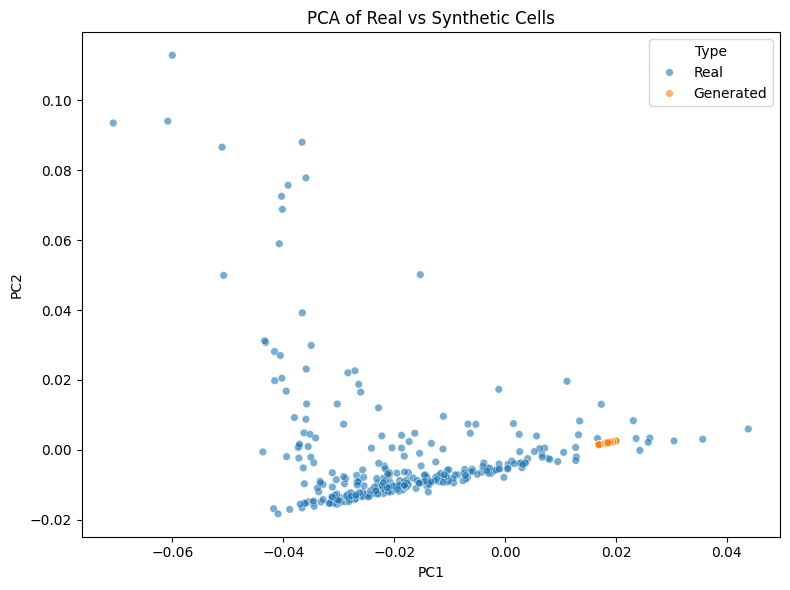

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)

df_plot = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Type': labels
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Type', alpha=0.6, s=30)
plt.title("PCA of Real vs Synthetic Cells")
plt.tight_layout()
plt.show()


# Step 2: Codebook Usage and Entropy

Count how many times each codebook entry is used

In [ ]:
model.eval()
all_indices = []

with torch.no_grad():
    for x_batch, in data_loader:
        _, _, _,_, indices = model(x_batch)
        all_indices.append(indices)

all_indices = torch.cat(all_indices).cpu().numpy()  # Now it's defined


In [ ]:
import numpy as np
from collections import Counter

# Assuming you already computed `all_indices`
codebook_usage = Counter(all_indices)
usage_vector = np.array([codebook_usage.get(i, 0) for i in range(model.codebook.shape[0])])

# Normalize to probabilities
prob_usage = usage_vector / usage_vector.sum()


In [ ]:
from collections import Counter
import numpy as np

codebook_usage = Counter(all_indices)
usage_vector = np.array([codebook_usage.get(i, 0) for i in range(model.codebook.shape[0])])
prob_usage = usage_vector / usage_vector.sum()

# Optional: Entropy
from scipy.stats import entropy
codebook_entropy = entropy(prob_usage)
print(f"Codebook Usage Entropy: {codebook_entropy:.4f}")


Codebook Usage Entropy: 0.0234


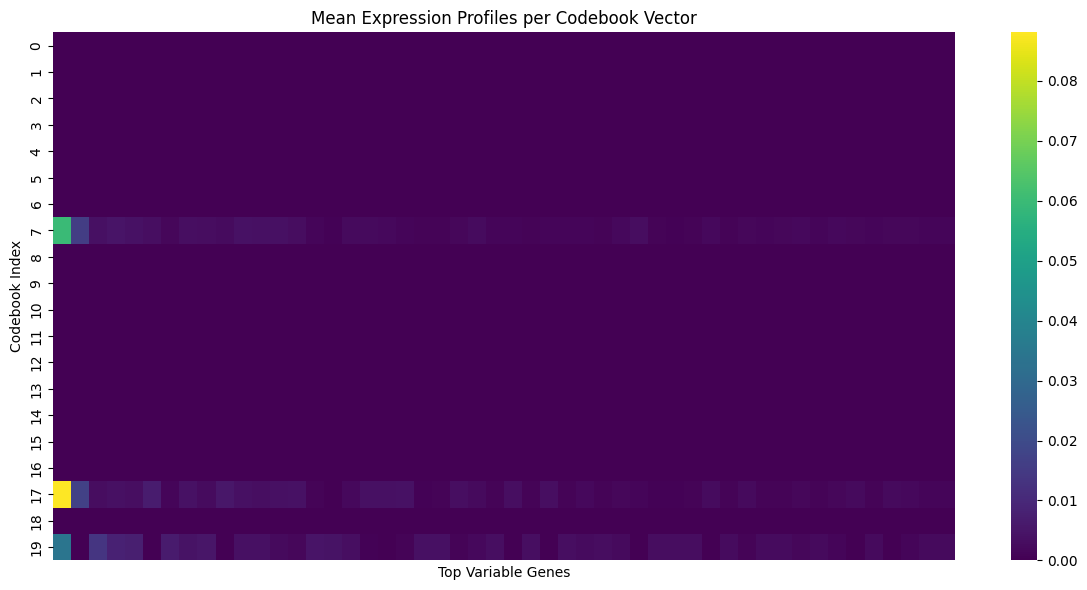

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

grouped_means = []

# Ensure each codebook vector is represented, even if unused
for k in range(model.codebook.shape[0]):
    assigned_mask = (all_indices == k)

    if assigned_mask.sum() > 0:
        # Mean across all cells assigned to codebook k
        mean_profile = X_tensor[assigned_mask].mean(dim=0).numpy()
    else:
        # Mark unused codebooks with NaNs for visibility in heatmap
        mean_profile = np.zeros(X_tensor.shape[1])

    grouped_means.append(mean_profile)

# Convert to DataFrame
df_means = pd.DataFrame(grouped_means)

# Optional: Subset genes (e.g., top 50 by variance)
top_var_genes = df_means.var(axis=0).sort_values(ascending=False).head(50).index
df_subset = df_means.loc[:, top_var_genes]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_subset, cmap='viridis', xticklabels=False, yticklabels=True)
plt.title('Mean Expression Profiles per Codebook Vector')
plt.xlabel('Top Variable Genes')
plt.ylabel('Codebook Index')
plt.tight_layout()
plt.show()


In [ ]:

model.eval()
all_indices = []

with torch.no_grad():
    for x_batch, in data_loader:
        _, _, _, _, indices = model(x_batch)  # if you're returning diversity_loss too
        all_indices.append(indices)

all_indices = torch.cat(all_indices).cpu().numpy()


import numpy as np
used_indices = np.unique(all_indices)
print(f"Used {len(used_indices)} / {model.codebook.shape[0]} codebook vectors")
print("Used indices:", used_indices)


Used 3 / 20 codebook vectors
Used indices: [ 7 17 19]
